# Fight Fuel: Combat-Sport Weight-Cut Optimizer
### Jeffrey Wang  
<br>

### Disclaimer
THIS IS A PERSONAL PROJECT DEVELOPED BY A STUDENT; IT IS NOT INTENDED TO PROVIDE PROFESSIONAL ADVICE ON NUTRITION OR TRAINING. USE AT YOUR OWN DISCRETION.

### Preface
I have recently developed an interest in Muay Thai (Thai kickboxing) and have been actively training. Although I have no plans to become a professional fighter, I thought it would be fun to build a tool to help fighters cut weight safely, efficiently, and transparently.

### Why Cut Weight?
Because weight is an inherent advantage in virtually every hand-to-hand combat sport (eg. boxing, wrestling, MMA etc.), weight classes exist at professional levels to facilitate fair competition. For professional fighters to compete at their optimal level, it is standard practice to exploit weight regulations by dieting and dehydrating to narrowly make weight, and then immediately refuel and rehydrate to recover weight before the fight.

### The Weight-Cutting Process
The weight-cutting process generally involves two steps:
1. Dieting
1. Dehydration

The first part of this process, dieting, usually begins 6–12 weeks before weigh-in. Because it can be unhealthy and even dangerous to cut too much body fat at once, dieting is ideally done through a gradual yet consistent process. Fighters will typically adhere to a multi-week structured diet plan to meet their weight goals.

The second part of this process, dehydration (or water cutting), is done via a sauna or other heat-inducing technology, and allows fighters to make weight without sacrificing their true body mass. However, excessive dehydration is dangerous so it is recommended to limit the weight lost from water cutting to 5% of fully hydrated body weight. Additionally, remaining in a dehydrated state for an extended period is unhealthy, so it is recommended to restrict water cutting to the day of weigh-in.

### Goal
This tool primarily focuses on the dieting portion of the weight-cutting process, aiming to formulate a structured diet plan to precisely meet weight goals while satisfying target levels of key-performance nutrients. However, the dehydration process is not overlooked, as the tool allocates up to 5% of body weight to be safely cut during the subsequent phase.

More precisely, the goal of this tool is to . . .
1. Optimize the athlete's nutrient intake to meet calorie limits while avoiding excessive dieting
1. Meet minimum intake requirements for vital nutrients, with higher targets for those essential to training and recovery
1. Ensure athlete safety by adhering to regulations and expert recommendations
1. Avoid foods that the athlete does not wish to eat

### TODO
- Explanations
- Need to account for impossible conditions . . .
    - Condition where it's impossible to meet every constraint
        - E.g. calorie cutoff and minimum nutrient levels
    - When required calorie deficit is higher than TDEE
    - Need constraint for maximum daily caloric deficit, cannot ask users to starve
- Resources
    - EAR and max intake: https://ods.od.nih.gov/HealthInformation/nutrientrecommendations.aspx
- rewrite deprecated behavior
- ensure code is written stably (.iloc vs .loc issue)
- generate visualizations for final results


### Step 1: Calculate Total Daily Energy Expenditure (TDEE) with User Input

For the tool to function properly, it requires several user inputs: height, weight, age, sex, target weight, and time until weigh-in. 

The user's height, weight, age, and sex are used to estimate their basal metabolic rate (BMR) with the [Mifflin-St Jeor equation](https://reference.medscape.com/calculator/846/mifflin-st-jeor-equation). BMR represents the amount of calories the user burns per day at complete rest. To estimate total daily energy expenditure (TDEE, or the actual number of calories burned accounting for activity), a fixed multiplier is applied to BMR: either `TRAIN_MULTI` or `REST_MULTI`, depending on whether the user is training or resting that day.

The last two inputs, target weight and time until weigh-in, are used in the next step.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pulp
import seaborn as sns

pd.set_option('future.no_silent_downcasting', True)

# sample user input
current_weight = 75 # kg
height = 185 # cm
age = 25
sex = 'male'
target_weight = 67 # kg, welterweight limit
days_until_weighin = 60

# ensure that age is between 14 and 70 to promote safe competition
if age < 14:
    raise ValueError("Age must be 14 or above, you may be too young to fight")
elif age > 70:
    raise ValueError("Age must be 70 or below, it may be time to retire")

# calculate basal metabolic rate (BMR)
def calc_bmr(weight, height, age, sex):
    '''
    Calculates basal metabolic rate (BMR) using the Mifflin-St Jeor equation.

    Args:
        weight (float): Weight in kg
        height (float): Height in cm
        age (int): Age in years
        sex (str): 'male' or 'female'

    Returns:
        float: Calculated BMR in kcal / day
    '''
    if sex == 'male':
        bmr = (10 * weight) + (6.25 * height) - (5 * age) + 5
    elif sex == 'female':
        bmr = (10 * weight) + (6.25 * height) - (5 * age) - 161
    else:
        raise ValueError('Input not recognized. Please enter "male" or "female" so the tool can account for biological differences in its calculations.')
    return bmr
bmr = calc_bmr(weight = current_weight, height = height, age = age, sex = sex) # basal metabolic rate (calories / day) calculated with Mifflin-St Jeor
print(f'BMR: {bmr:.2f} kcal')

# predict average total daily energy expenditure (kcal) for training days
TRAIN_MULTI = 1.8
train_tdee = TRAIN_MULTI * bmr
print(f'Training-Day TDEE: {train_tdee:.2f} kcal')

# predict average total daily energy expenditure (kcal) for rest days
REST_MULTI = 1.2
rest_tdee = REST_MULTI * bmr
print(f'Rest-Day TDEE: {rest_tdee:.2f} kcal')

BMR: 1786.25 kcal
Training-Day TDEE: 3215.25 kcal
Rest-Day TDEE: 2143.50 kcal


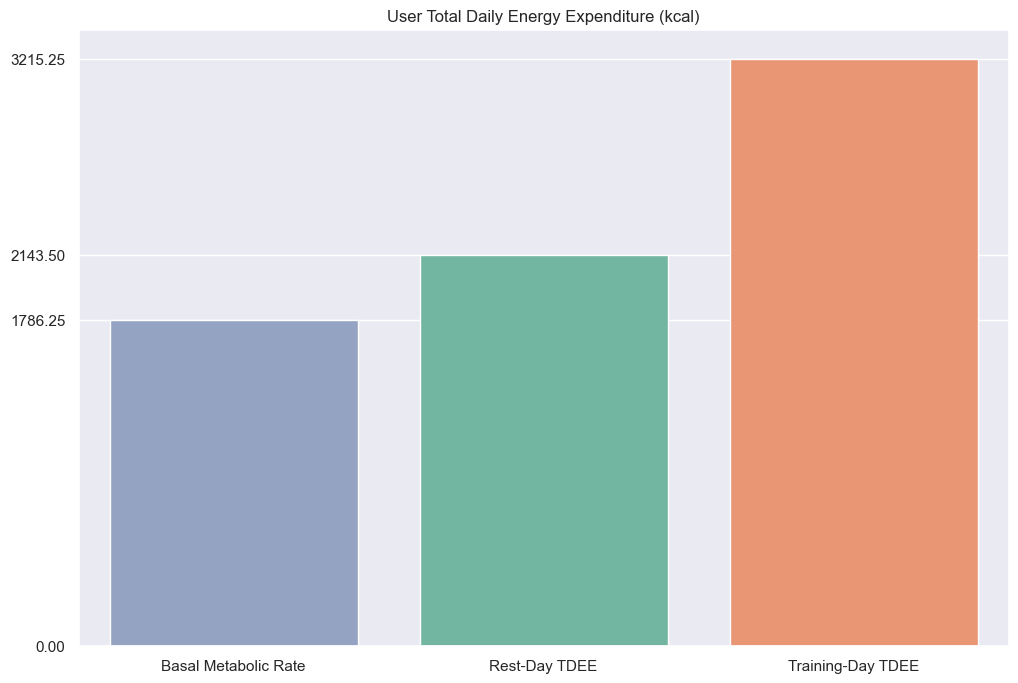

In [2]:
# code for generating visualization

# data
metrics = ['Basal Metabolic Rate', 'Rest-Day TDEE', 'Training-Day TDEE']
values = [bmr, rest_tdee, train_tdee]

# presets
sns.set_theme(style='darkgrid')
palette = sns.color_palette('Set2')

# plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x=metrics, y=values, palette=[palette[2], palette[0], palette[1]], hue=metrics)

# formatting
plt.title("User Total Daily Energy Expenditure (kcal)")
plt.xlabel('')
plt.ylabel('')
yticks = [0, bmr, rest_tdee, train_tdee]
ytick_labels = [f'{v:.2f}' for v in yticks]
plt.yticks(yticks, ytick_labels)
plt.show()

*This visualization shows the metrics used to represent daily energy consumption, and how the user's values vary.*

<br>

### Step 2: Determine Maximum Daily Caloric Intake
Once the user's TDEE values are calculated, they are combined with the user's `target_weight` and `days_until_weighin` to determine the daily caloric intake needed to meet the target weight by weigh-in.

To accomplish this, the tool will first determine how much weight to allocate to the water cutting (dehydration) process.

Generally, the ideal ratio between dieting and water cutting for professional fighters is around 50:50 (assuming the maximum safe 5% water-cutting limit is met). However, this balance depends on body fat percentage; because most professional fighters are quite lean, they have less fat to lose through dieting and rely more heavily on dehydration to make weight. However, fighters with higher body fat percentage can aim for a more diet-heavy ratio, such as 75:25, to avoid the risks of excessive dehydration. The `diet_to_dehydrate_ratio` variable, which is 0.5 (50:50) by default, can be adjusted to better accomodate users with different body compositions or goals.

In [3]:
# split weight-cut goal into diet and dehydration goals
diet_to_dehydrate_ratio = 0.5 # ratio of weight lost from dieting to weight lost from dehydration, change depending on goals
total_cut_goal = current_weight - target_weight # total amount of weight to cut before weigh-in
print(f'Total Weight-Loss Goal: {total_cut_goal:.2f} kg')

# aim for the targeted diet to dehydration ratio, unless dehydration exceeds safe limits
MAX_DEHYDRATE_PERCENT = 0.05 # maximum amount of body weight % that can be cut safely from dehydration
max_dehydrate_amt = target_weight / (1 - MAX_DEHYDRATE_PERCENT) - target_weight # max amount of user's body weight that can be safely cut from dehydration

# if goal exceeds safe limits, then adjust goal to upper limit
dehydrate_goal = min(total_cut_goal * diet_to_dehydrate_ratio, max_dehydrate_amt) # kg to lose from dehydration
print(f'Dehydration Weight-Loss Goal: {dehydrate_goal:.2f} kg')

# after accounting for dehydration, the remaining weight must be cut from dieting
diet_goal = total_cut_goal - dehydrate_goal
print(f'Dieting Weight-Loss Goal: {diet_goal:.2f} kg')

Total Weight-Loss Goal: 8.00 kg
Dehydration Weight-Loss Goal: 3.53 kg
Dieting Weight-Loss Goal: 4.47 kg


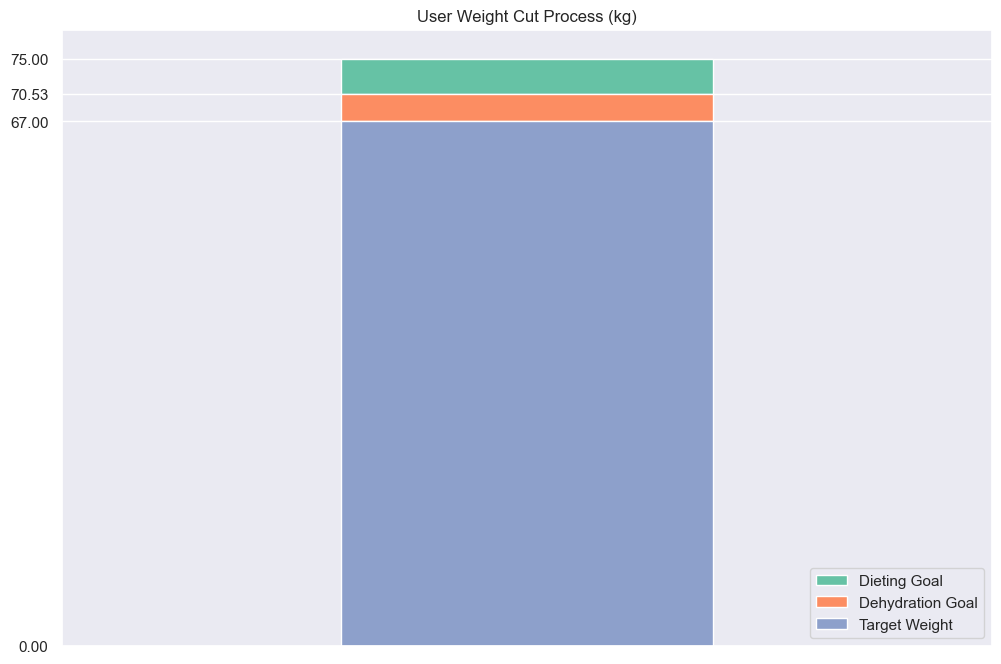

In [4]:
# code for generating visualization

# plot
plt.figure(figsize=(12, 8))
plt.bar(0, diet_goal, bottom=target_weight+dehydrate_goal, label='Dieting Goal', color=palette[0])
plt.bar(0, dehydrate_goal, bottom=target_weight, label='Dehydration Goal', color=palette[1])
plt.bar(0, target_weight, label='Target Weight', color=palette[2])

# formatting
plt.xlim(-1, 1)
plt.xticks([])
plt.yticks([0, target_weight, target_weight + dehydrate_goal, current_weight])
plt.legend(loc='lower right')
plt.title('User Weight Cut Process (kg)')
plt.show()

*This visualization illustrates the weight-cutting process from dieting to dehydration, as well as the proportion of weight the user should cut during each phase, compared to their body weight*

<br>

Once the weight allocated to the dehydration phase is determined, the remainder becomes the target for the dieting phase. This weight (kg) is divided by `days_until_weighin` to set a daily weight-loss goal.

The daily weight-loss goal (kg) is then converted to its energy equivalent (kcal) to determine the corresponding caloric deficit necessary.

With the TDEE values calculated from step 1, we can then determine the maximum daily caloric intake on training and rest days. These are the target calorie levels that the dieting tool will aim for when recommending a daily diet plan.

In [5]:
# calculate daily dieting goal
daily_diet_goal = diet_goal / days_until_weighin # kg to lose per day from dieting to make weight
print(f'Daily Dieting Weight-Loss Goal: {daily_diet_goal * 1000:.2f} g') # displayed in g, not kg

# calculate daily caloric deficit
BODY_WEIGHT_TO_CALORIES = 7700 # amount of caloric deficit required to lose 1 kg of body weight
daily_caloric_deficit = BODY_WEIGHT_TO_CALORIES * daily_diet_goal # amount of calorie deicit per day required to make weight
print(f'Daily Caloric Deficit: {daily_caloric_deficit:.2f} kcal')

calorie_goal_train = train_tdee - daily_caloric_deficit
print(f'Training-Day Calorie Limit: {calorie_goal_train:.2f} kcal')

calorie_goal_rest = rest_tdee - daily_caloric_deficit
print(f'Rest-Day Calorie Limit: {calorie_goal_rest:.2f} kcal')

Daily Dieting Weight-Loss Goal: 74.56 g
Daily Caloric Deficit: 574.12 kcal
Training-Day Calorie Limit: 2641.13 kcal
Rest-Day Calorie Limit: 1569.38 kcal


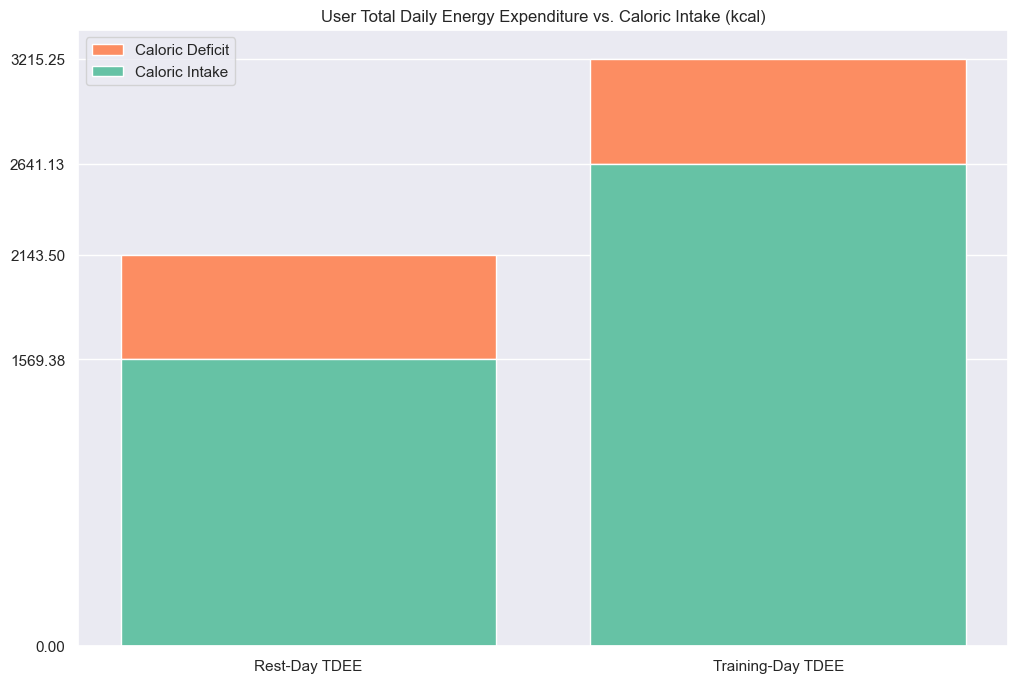

In [6]:
# code for generating visualization

# data
labels = ['Rest-Day TDEE', 'Training-Day TDEE']

# plot
plt.figure(figsize=(12, 8))
plt.bar(labels[0], daily_caloric_deficit, bottom=calorie_goal_rest, label='Caloric Deficit', color=palette[1])
plt.bar(labels[0], calorie_goal_rest, label='Caloric Intake', color=palette[0])
plt.bar(labels[1], daily_caloric_deficit, bottom=calorie_goal_train, color=palette[1])
plt.bar(labels[1], calorie_goal_train, color=palette[0])

# formatting
plt.title('User Total Daily Energy Expenditure vs. Caloric Intake (kcal)')
plt.grid(axis='x', visible=False) # disable vertical gridlines
yticks = [0, rest_tdee, calorie_goal_rest, train_tdee, calorie_goal_train]
ytick_labels = [f'{v:.2f}' for v in yticks]
plt.yticks(yticks, ytick_labels)
plt.legend(loc='best')
plt.show()

*This visualization illustrates how the user's daily caloric intake is derived from their total daily energy expenditure (TDEE) and daily caloric deficit.*

<br>

### Step 3: Data Wrangling

Next, I imported and cleaned a few datasets that define the tool's optimization goals and contraints:
1. `food_df`: A dataset that contains different foods and their nutritional values
1. `ear_df`: A dataset containing the estimated average requirement (EAR) of each nutrient for people of different ages and sexes. Because this amount is only sufficient for around 50% of the population, it serves as an appropriate lower limit.
1. `max_nutrients_df`: Merged from `max_vitamins_df` and `maximum_elements_df`, datasets containing the maximum tolerable intake for each nutrient

First I imported and cleaned `food_df`. Below is the data frame before cleaning.

In [7]:
# 1. food_df
food_df = pd.read_excel('data/2021-2023 FNDDS At A Glance - FNDDS Nutrient Values.xlsx', header=1) # read data, first row contains headers
food_df.head(10)

,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),...,20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
0,11100000,"Milk, NFS",1004,"Milk, reduced fat",52,3.33,4.83,4.88,0.0,2.14,...,0.002,0.0,0.074,0.008,0.0,0.003,0.000,0.001,0.0,88.92
1,11111000,"Milk, whole",1002,"Milk, whole",61,3.27,4.63,4.81,0.0,3.20,...,0.004,0.0,0.115,0.013,0.0,0.004,0.001,0.002,0.0,88.10
2,11112110,"Milk, reduced fat (2%)",1004,"Milk, reduced fat",50,3.36,4.90,4.89,0.0,1.90,...,0.002,0.0,0.061,0.007,0.0,0.003,0.000,0.001,0.0,89.10
3,11112210,"Milk, low fat (1%)",1006,"Milk, lowfat",43,3.38,5.18,4.96,0.0,0.95,...,0.001,0.0,0.033,0.004,0.0,0.001,0.000,0.000,0.0,89.70
4,11113000,"Milk, fat free (skim)",1008,"Milk, nonfat",34,3.43,4.92,5.05,0.0,0.08,...,0.000,0.0,0.005,0.000,0.0,0.000,0.000,0.000,0.0,90.80
5,11114300,"Milk, lactose free, low fat (1%)",1006,"Milk, lowfat",43,3.38,5.18,4.96,0.0,0.95,...,0.001,0.0,0.033,0.004,0.0,0.001,0.000,0.000,0.0,89.70
6,11114320,"Milk, lactose free, fat free (skim)",1008,"Milk, nonfat",34,3.43,4.92,5.05,0.0,0.08,...,0.000,0.0,0.005,0.000,0.0,0.000,0.000,0.000,0.0,90.80
7,11114330,"Milk, lactose free, reduced fat (2%)",1004,"Milk, reduced fat",50,3.36,4.90,4.89,0.0,1.90,...,0.002,0.0,0.061,0.007,0.0,0.003,0.000,0.001,0.0,89.10
8,11114350,"Milk, lactose free, whole",1002,"Milk, whole",61,3.27,4.63,4.81,0.0,3.20,...,0.004,0.0,0.115,0.013,0.0,0.004,0.001,0.002,0.0,88.10
9,11115300,Buttermilk,1002,"Milk, whole",43,3.46,4.81,5.36,0.0,1.08,...,0.000,0.0,0.022,0.013,0.0,0.000,0.000,0.000,0.0,89.79


Here's an overview of the cleaning I performed:
1. Drop column names to lowercase for ease of access
1. Remove leading / trailing spaces from column names to avoid string-matching issues
1. Replace all invisible characters (spaces, tabs, newlines [`\n`], non-breaking spaces [`&nbsp;`], etc.) with underscores.
1. Replace row-number indices with unique food codes for ease of access 
1. Rename columns according to a standardized dictionary for naming consistency accross data frames
1. Drop overlapping columns (e.g. `vitamin_e_added_mcg` if a column for total Vitamin E exists)

Below is the resulting table after cleaning.

In [8]:
# clean column names
food_df.columns = (
    food_df.columns
    .str.lower() # drop column names to lowercase
    .str.strip() # remove leading and trailing spaces
    .str.replace(r'\s+', '_', regex=True) # replace spaces, tabs, etc. with underscores
    .str.replace(r'[,()-]', '', regex=True) # remove commas, parentheses, hyphens
    .str.replace('+', 'and')
)

# dictionary for naming consistency
nutrient_dict = {
    'cho_g': 'carbohydrate_g',
    'choline_total_mg': 'choline_mg',
    'sugars_total_g': 'sugars_g',
    'fiber_total_dietary_g': 'fiber_g',
    'total_fat_g': 'fat_g',
    'vitamin_a_mcg': 'vitamin_a_rae_mcg',
    'vitamin_a_rae_mcg_rae': 'vitamin_a_rae_mcg',
    'folate_mcg': 'folate_dfe_mcg',
    'folate_dfe_mcg_dfe': 'folate_dfe_mcg',
    'vitamin_d_d2_and_d3_mcg': 'vitamin_d_mcg',
    'vitamin_e_alphatocopherol_mg': 'vitamin_e_mg',
    'vitamin_k_phylloquinone_mcg': 'vitamin_k_mcg',
}

# rename / drop columns
food_df = (
    food_df
    .set_index('food_code') # replace row-number indices with unique food codes for ease of access 
    .rename(columns=nutrient_dict) # rename column names according to nutrient_dict
    .drop( # drop overlapping columns
        columns=list(food_df.loc[:, '4:0_g':'22:6_n3_g'].columns) + [
            # included in fat_g
            'fatty_acids_total_saturated_g', 
            'fatty_acids_total_monounsaturated_g',
            'fatty_acids_total_polyunsaturated_g',
            # included in vitamin_a_rae_mcg
            'retinol_mcg',
            'carotene_alpha_mcg', 
            'carotene_beta_mcg',
            'cryptoxanthin_beta_mcg',
            # included in folate_dfe_mcg
            'folic_acid_mcg',
            'folate_food_mcg',
            'folate_total_mcg',
            # included in vitamin_b12_mcg
            'vitamin_b12_added_mcg',
            # included in vitamin_e_mg
            'vitamin_e_added_mg',
        ]
    )
)

food_df.head(10)

,main_food_description,wweia_category_number,wweia_category_description,energy_kcal,protein_g,carbohydrate_g,sugars_g,fiber_g,fat_g,cholesterol_mg,...,iron_mg,zinc_mg,copper_mg,selenium_mcg,potassium_mg,sodium_mg,caffeine_mg,theobromine_mg,alcohol_g,water_g
food_code,,,,,,,,,,,,,,,,,,,,,
11100000,"Milk, NFS",1004,"Milk, reduced fat",52,3.33,4.83,4.88,0.0,2.14,9,...,0.00,0.43,0.001,1.9,156,39,0,0,0.0,88.92
11111000,"Milk, whole",1002,"Milk, whole",61,3.27,4.63,4.81,0.0,3.20,12,...,0.00,0.42,0.001,1.9,150,38,0,0,0.0,88.10
11112110,"Milk, reduced fat (2%)",1004,"Milk, reduced fat",50,3.36,4.90,4.89,0.0,1.90,8,...,0.00,0.43,0.001,1.8,159,39,0,0,0.0,89.10
11112210,"Milk, low fat (1%)",1006,"Milk, lowfat",43,3.38,5.18,4.96,0.0,0.95,5,...,0.00,0.43,0.001,2.1,159,39,0,0,0.0,89.70
11113000,"Milk, fat free (skim)",1008,"Milk, nonfat",34,3.43,4.92,5.05,0.0,0.08,3,...,0.00,0.45,0.002,2.0,167,41,0,0,0.0,90.80
11114300,"Milk, lactose free, low fat (1%)",1006,"Milk, lowfat",43,3.38,5.18,4.96,0.0,0.95,5,...,0.00,0.43,0.001,2.1,159,39,0,0,0.0,89.70
11114320,"Milk, lactose free, fat free (skim)",1008,"Milk, nonfat",34,3.43,4.92,5.05,0.0,0.08,3,...,0.00,0.45,0.002,2.0,167,41,0,0,0.0,90.80
11114330,"Milk, lactose free, reduced fat (2%)",1004,"Milk, reduced fat",50,3.36,4.90,4.89,0.0,1.90,8,...,0.00,0.43,0.001,1.8,159,39,0,0,0.0,89.10
11114350,"Milk, lactose free, whole",1002,"Milk, whole",61,3.27,4.63,4.81,0.0,3.20,12,...,0.00,0.42,0.001,1.9,150,38,0,0,0.0,88.10


Next I imported and cleaned `ear_df`, the data frame containing the EAR (Estimated Average Requirement) for each nutrient. Below is the data frame before cleaning.

In [9]:
# 2. ear_df
ear_df = pd.read_excel('data/Estimated Average Requirements.xlsx')
ear_df.head(10)

,Life-Stage Group,Calcium (mg/d),CHO (g/d),Protein (g/kg/d),Vitamin A (Rg/d),Vitamin C (mg/d),Vitamin D (Rg/d),Vitamin E (mg/d),Thiamin (mg/d),Riboflavin (mg/d),...,Folate (Rg/d),Vitamin B12 (Rg/d),Copper (Rg/d),Iodine (Rg/d),Iron (mg/d),Magnesium (mg/d),Molybdenum (Rg/d),Phosphorus (mg/d),Selenium (Rg/d),Zinc (mg/d)
0,Infants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0–6 mo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7–12 mo,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.9,NaN,NaN,NaN,NaN,2.5
3,Children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1–3 y,500.0,100.0,0.87,210.0,13.0,10.0,5.0,0.4,0.4,...,120.0,0.7,260.0,65.0,3.0,65.0,13.0,380.0,17.0,2.5
5,4–8 y,800.0,100.0,0.76,275.0,22.0,10.0,6.0,0.5,0.5,...,160.0,1.0,340.0,65.0,4.1,110.0,17.0,405.0,23.0,4.0
6,Males,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9–13 y,1100.0,100.0,0.76,445.0,39.0,10.0,9.0,0.7,0.8,...,250.0,1.5,540.0,73.0,5.9,200.0,26.0,1055.0,35.0,7.0
8,14–18 y,1100.0,100.0,0.73,630.0,63.0,10.0,12.0,1.0,1.1,...,330.0,2.0,685.0,95.0,7.7,340.0,33.0,1055.0,45.0,8.5
9,19–30 y,800.0,100.0,0.66,625.0,75.0,10.0,12.0,1.0,1.1,...,320.0,2.0,700.0,95.0,6.0,330.0,34.0,580.0,45.0,9.4


I repeated the process used on the first data frame, along with some additional steps:

1. Standardize and convert units in columns (e.g. protein [g/kg] was adjusted based on the user's target body weight and converted to grams [g]). Notably, this dataset unconventionally uses "Rg" to represent micrograms (mcg), which I corrected to the standard denotation
1. Drop every "Life-Stage Group" row that could not contain professional fighters, such as infants and pregnant women
1. Split the "Life-Stage Group" column into "Age" and "Sex" columns and set them as a two-level multiindex for the data frame to improve ease of access (the remaining groups could simply be classified by age and sex)
1. Eliminate indistinguishable characters (e.g. hyphen [-] and en-dash [–]) to prevent string-matching issues. For example, in the newly created "Age" column, I replaced the en-dashes with "to" (e.g. 9–13 became 9_to_13)
1. Ensure that the new column names match the names in other data frames by printing unique columns.

Below is the EAR data frame after wrangling:

In [10]:
# clean column names
ear_df.columns = (
    ear_df.columns
    .str.lower()
    .str.strip()
    .str.replace(r'[\s-]+', '_', regex=True)
    .str.replace(r'[,()]', '', regex=True)
    .str.replace('rg', 'mcg') # standardize microgram denotation
    .str.replace('/d', '') # remove "per day" from units for consistency
)

# rename columns
ear_df = (ear_df
          .rename(columns=nutrient_dict)
          .rename(columns={'protein_g/kg': 'protein_g', 'copper_mcg': 'copper_mg'}) # standardize units
)

# convert renamed columns to respective unit
ear_df['protein_g'] *= target_weight # convert Protein from g/kg to g
ear_df['copper_mg'] *= 0.001 # convert Copper from mcg to mg

# keep only life-stage groups that can contain professional fighters
ear_df = pd.concat([
    ear_df.iloc[8:12, :], # male rows
    ear_df.iloc[15:19, :] # female rows
])

# split "Life-Stage Group" into "Age" and "Sex"
ear_df = ear_df.rename(columns={'life_stage_group': 'age'}) 
ear_df.loc[8:12, 'sex'], ear_df.loc[15:19, 'sex'] = 'male', 'female'

# clean "Age" column
ear_df['age'] = (
    ear_df['age']
    .str.replace('–', '_') # replace en-dash with underscore
    .str.replace(' y', '') # remove " y" at the end of ages
    .str.strip() # remove leading and trailing spaces
)

# set "Age" and "Sex" as two-leve; multiindex
ear_df = ear_df.set_index(['sex', 'age']) 

# ensure column names match other data frames
diff = ear_df.columns.difference(food_df.columns)
print(f'Unique Columns: {list(diff)}') # print the column names that differ from other data frames

ear_df.head(20)

Unique Columns: ['iodine_mcg', 'molybdenum_mcg']


calcium_mg  carbohydrate_g  protein_g  vitamin_a_rae_mcg  \
sex    age                                                               
male   14_18      1100.0           100.0      48.91              630.0   
       19_30       800.0           100.0      44.22              625.0   
       31_50       800.0           100.0      44.22              625.0   
       51_70       800.0           100.0      44.22              625.0   
female 14_18      1100.0           100.0      47.57              485.0   
       19_30       800.0           100.0      44.22              500.0   
       31_50       800.0           100.0      44.22              500.0   
       51_70      1000.0           100.0      44.22              500.0   

              vitamin_c_mg  vitamin_d_mcg  vitamin_e_mg  thiamin_mg  \
sex    age                                                            
male   14_18          63.0           10.0          12.0         1.0   
       19_30          75.0           10.0          12.0         1.0   
       31_50          75.0           10.0          12.0         1.0   
       51_70          75.0           10.0          12.0         1.0   
female 14_18          56.0           10.0          12.0         0.9   
       19_30          60.0           10.0          12.0         0.9   
       31_50          60.0           10.0          12.0         0.9   
       51_70          60.0           10.0          12.0         0.9   

              riboflavin_mg  niacin_mg  ...  folate_dfe_mcg  vitamin_b12_mcg  \
sex    age                              ...                                    
male   14_18            1.1       12.0  ...           330.0              2.0   
       19_30            1.1       12.0  ...           320.0              2.0   
       31_50            1.1       12.0  ...           320.0              2.0   
       51_70            1.1       12.0  ...           320.0              2.0   
female 14_18            0.9       11.0  ...           330.0              2.0   
       19_30            0.9       11.0  ...           320.0              2.0   
       31_50            0.9       11.0  ...           320.0              2.0   
       51_70            0.9       11.0  ...           320.0              2.0   

              copper_mg  iodine_mcg  iron_mg  magnesium_mg  molybdenum_mcg  \
sex    age                                                                   
male   14_18      0.685        95.0      7.7         340.0            33.0   
       19_30      0.700        95.0      6.0         330.0            34.0   
       31_50      0.700        95.0      6.0         350.0            34.0   
       51_70      0.700        95.0      6.0         350.0            34.0   
female 14_18      0.685        95.0      7.9         300.0            33.0   
       19_30      0.700        95.0      8.1         255.0            34.0   
       31_50      0.700        95.0      8.1         265.0            34.0   
       51_70      0.700        95.0      5.0         265.0            34.0   

              phosphorus_mg  selenium_mcg  zinc_mg  
sex    age                                          
male   14_18         1055.0          45.0      8.5  
       19_30          580.0          45.0      9.4  
       31_50          580.0          45.0      9.4  
       51_70          580.0          45.0      9.4  
female 14_18         1055.0          45.0      7.3  
       19_30          580.0          45.0      6.8  
       31_50          580.0          45.0      6.8  
       51_70          580.0          45.0      6.8  

[8 rows x 21 columns]

In [11]:
max_vitamins_df = pd.read_excel('data/Tolerable Upper Intake Levels, Vitamins.xlsx')
max_elements_df = pd.read_excel('data/Tolerable Upper Intake Levels, Elements.xlsx')

max_vitamins_df.head(10)

,Life-Stage Group,Vitamin A (μg/d),Vitamin C (mg/d),Vitamin D (μg/d),Vitamin E (mg/d),Vitamin K,Thiamin,Riboflavin,Niacin (mg/d),Vitamin B6 (mg/d),Folate (μg/d),Vitamin B12,Pantothenic Acid,Biotin,Choline (g/d),Carotenoids
0,Infants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0–6 mo,600.0,ND,25.0,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
2,6–12 mo,600.0,ND,38.0,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
3,Children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1–3 y,600.0,400,63.0,200,ND,ND,ND,10,30,300,ND,ND,ND,1,ND
5,4–8 y,900.0,650,75.0,300,ND,ND,ND,15,40,400,ND,ND,ND,1,ND
6,Males,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9–13 y,1700.0,1200,100.0,600,ND,ND,ND,20,60,600,ND,ND,ND,2,ND
8,14–18 y,2800.0,1800,100.0,800,ND,ND,ND,30,80,800,ND,ND,ND,3,ND
9,19–30 y,3000.0,2000,100.0,1000,ND,ND,ND,35,100,1000,ND,ND,ND,3.5,ND


In [12]:
max_elements_df = max_elements_df.drop(columns='Life-Stage Group') # drop to avoid duplicate 'Life-Stage Group' column after merging
max_nutrients_df = pd.concat([max_vitamins_df, max_elements_df], axis=1) # merge vitamins and elements into 1 data frame

max_nutrients_df = pd.concat([
    max_nutrients_df.iloc[8:12, :], # male rows
    max_nutrients_df.iloc[15:19, :] # female rows
])

max_nutrients_df.columns = (
    max_nutrients_df.columns
    .str.lower()
    .str.strip()
    .str.replace(r'[\s-]+', '_', regex=True)
    .str.replace(r'[(),]', '', regex=True)  # remove ( and )
    .str.replace('μg', 'mcg')   # keep "micro" units consistent
    .str.replace('/d', '') # remove "per day" from units for consistency
)

max_nutrients_df = (
    max_nutrients_df
    .rename(columns=nutrient_dict)
    .rename(columns={'choline_g': 'choline_mg', 'copper_mcg': 'copper_mg', 'phosphorus_g': 'phosphorus_mg'})
)

max_nutrients_df['choline_mg'] *= 1000 # convert Choline from g to mg for consistency
max_nutrients_df['copper_mg'] *= 0.001 # convert Copper from mcg to mg for consistency
max_nutrients_df['phosphorus_mg'] *= 1000 # convert Phosphorus from g to mg for consistency

max_nutrients_df = max_nutrients_df.rename(columns={'life_stage_group': 'age'}) # break "Life-Stage Group" into "Sex" and "Age"
max_nutrients_df.loc[8:12, 'sex'], max_nutrients_df.loc[15:19, 'sex'] = 'male', 'female'

max_nutrients_df['age'] = (
    max_nutrients_df['age']
    .str.strip()
    .str.replace('–', '_') # replace en-dash with underscore
    .str.replace(' y', '') # remove " y" at the end of ages 
)
max_nutrients_df = max_nutrients_df.set_index(['sex', 'age'])

max_nutrients_df = max_nutrients_df.replace('ND', np.nan).dropna(axis=1, how='all') # set ND as NaN, drop col if all values are NaN

diff = max_nutrients_df.columns.difference(food_df.columns)
print(f'Unique Columns: {list(diff)}') # print the column names that differ from other data frames

max_nutrients_df = max_nutrients_df.drop(columns=diff)
max_nutrients_df.head(10)


Unique Columns: ['boron_mg', 'fluoride_mg', 'iodine_mcg', 'manganese_mg', 'molybdenum_mcg', 'nickel_mg']


vitamin_a_rae_mcg vitamin_c_mg  vitamin_d_mcg vitamin_e_mg  \
sex    age                                                                 
male   14_18             2800.0         1800          100.0          800   
       19_30             3000.0         2000          100.0         1000   
       31_50             3000.0         2000          100.0         1000   
       51_70             3000.0         2000          100.0         1000   
female 14_18             2800.0         1800          100.0          800   
       19_30             3000.0         2000          100.0         1000   
       31_50             3000.0         2000          100.0         1000   
       51_70             3000.0         2000          100.0         1000   

             niacin_mg vitamin_b6_mg folate_dfe_mcg choline_mg  calcium_mg  \
sex    age                                                                   
male   14_18        30            80            800       3000      3000.0   
       19_30        35           100           1000     3500.0      2500.0   
       31_50        35           100           1000     3500.0      2500.0   
       51_70        35           100           1000     3500.0      2000.0   
female 14_18        30            80            800       3000      3000.0   
       19_30        35           100           1000     3500.0      2500.0   
       31_50        35           100           1000     3500.0      2500.0   
       51_70        35           100           1000     3500.0      2000.0   

             copper_mg  iron_mg magnesium_mg phosphorus_mg  selenium_mcg  
sex    age                                                                
male   14_18       8.0     45.0          350          4000         400.0  
       19_30      10.0     45.0          350          4000         400.0  
       31_50      10.0     45.0          350          4000         400.0  
       51_70      10.0     45.0          350          4000         400.0  
female 14_18       8.0     45.0          350          4000         400.0  
       19_30      10.0     45.0          350          4000         400.0  
       31_50      10.0     45.0          350          4000         400.0  
       51_70      10.0     45.0          350          4000         400.0

In [13]:
def optimize_diet(caloric_intake):
    problem = pulp.LpProblem('diet_problem', pulp.LpMinimize) # min difference between daily weight reduction goal and caloric intake
    
    # variables
    amt_vars = pulp.LpVariable.dicts(name='food amt', indices=food_df.index, lowBound = 0) # indices are food codes
    selected_vars = pulp.LpVariable.dicts(name='selected', indices=food_df.index, cat='Binary')
    pos_diff = pulp.LpVariable('pos_diff', lowBound=0)
    neg_diff = pulp.LpVariable('neg_diff', lowBound=0)

    total_calories = pulp.lpSum([amt_vars[food_code] * food_df.loc[food_code, 'energy_kcal'] for food_code in food_df.index])

    # objective function
    problem += pos_diff + neg_diff

    # constraints
    problem += caloric_intake - total_calories == pos_diff - neg_diff, 'model_difference'

    age_group = ''
    if 14 <= age <= 18:
        age_group = '14_18'
    elif 19 <= age <= 30:
        age_group = '19_30'
    elif 31 <= age <= 50:
        age_group = '31_50'
    elif 51 <= age <= 70:
        age_group = '51_70'

    # min intake constraints
    min_nutrients = pd.Series(index=food_df.columns)[3:].fillna(0) # default minimum is 0

    # fill in minimum amount constraints according to EAR, if recommended amount exists
    for nutrient in ear_df.columns:
        if nutrient in min_nutrients.index: # check if nutrient exists in food df
            min_nutrients[nutrient] = ear_df.loc[(sex, age_group), nutrient]

            # increased minimum amounts for key performance nutrients

    # macros
    min_nutrients['protein_g'] = 2.0 * target_weight
    min_nutrients['carbohydrate_g'] = 4.0 * target_weight
    min_nutrients['fat_g'] = 1.0 * target_weight

    # electrolytes: muscle cramp prevention
    min_nutrients['sodium_mg'] = 500.0
    min_nutrients['potassium_mg'] = 4000.0

    # below values are lower than ear values
    min_nutrients['magnesium_mg'] = 300.0
    min_nutrients['calcium_mg'] = 1000.0 # muscle + bone health

    # b vitamins: critical for energy metabolism
    min_nutrients['thiamin_mg'] = 1.2
    min_nutrients['riboflavin_mg'] = 1.3
    min_nutrients['niacin_mg'] = 16.0
    min_nutrients['vitamin_b6_mg'] = 1.3
    min_nutrients['vitamin_b12_mcg'] = 2.4

    # other
    min_nutrients['iron_mg'] = 10.0 # oxygen transport — key for endurance
    # min_nutrients['omega-3 (epa + dha) (g)'] = 1.5 # anti-inflammatory, 20:5 is epa, 22:6 is dha
    min_nutrients['vitamin_d_mcg'] = 10.0 # often supplemented — immunity, bone
    min_nutrients['zinc_mg'] = 10.0 # recovery, immune support
    min_nutrients['vitamin_c_mg'] = 75.0 # immunity, collagen
    min_nutrients['fiber_g'] = 25.0 # too much can bloat during cut phase

    for nutrient in min_nutrients.index:
        if nutrient in food_df.columns:
            problem += pulp.lpSum([amt_vars[food_code] * food_df.loc[food_code, nutrient] for food_code in food_df.index]) >= min_nutrients[nutrient], f'min_{nutrient}'
        else:
            print(f"Warning: {nutrient} not found in food_df columns.")

    # TODO: change this
    max_nutrients = pd.Series(index=food_df.columns)[3:].fillna(999999999) # no maximum by default
    max_nutrients_df['caffeine_mg'] = [100, 400, 400, 400, 100, 400, 400, 400] # limit caffeine to 100 mg for children, 400 mg for adults

    # fill in minimum amount constraints according to maximum daily intake levels, if recommended amount exists
    for nutrient in max_nutrients_df.columns:
        if nutrient in max_nutrients.index: # check if nutrient exists in food df
            max_nutrients[nutrient] = max_nutrients_df.loc[(sex, age_group), nutrient]

    for nutrient in max_nutrients.index:
        if nutrient in food_df.columns:
            problem += pulp.lpSum([amt_vars[food_code] * food_df.loc[food_code, nutrient] for food_code in food_df.index]) <= max_nutrients[nutrient], f'max_{nutrient}'
        else:
            print(f"Warning: {nutrient} not found in food_df columns.")

    # constraint 3: min 0.5 servings
    for food_code in food_df.index:
        problem += amt_vars[food_code] >= 0.1 * selected_vars[food_code]
        problem += amt_vars[food_code] <= 5 * selected_vars[food_code] # linking constraint to ensure that 'selected' is 1 when 'food amt' > 0

    from collections import defaultdict

    # constraint 4: max 1 food from each category
    category_foods = defaultdict(list)
    for food_code, category in food_df['wweia_category_number'].items():
        category_foods[category].append(food_code)
    for category, food_codes in category_foods.items():
        problem += pulp.lpSum(selected_vars[food_code] for food_code in food_codes) <= 1, f'one_per_category_{category}'

    # Constraint: unwanted foods (such as baby food)
    problem += pulp.lpSum(selected_vars[food_code] for food_code in category_foods[9002]) == 0, f'no_baby_food_{food_df.loc[food_code]}'

    # macro kcal/g
    CARB_KCAL_PER_G = 4
    FAT_KCAL_PER_G = 9
    PROTEIN_KCAL_PER_G = 4

    # total_energy = CARB_KCAL_PER_G * amt_vars['Carbohydrate (g)'] + FAT_KCAL_PER_G * amt_vars['Total Fat (g)'] + PROTEIN_KCAL_PER_G * amt_vars['Protein (g)']

    # print(min_nutrients.index)
    # print(food_df.loc[11114300, 'Zinc (mg)'])

    # solve w/o printing output
    problem.solve(pulp.PULP_CBC_CMD(msg=False))

    total_caff = 0
    total_energy = 0
    total_protein = 0
    # print non-zero results
    for food_code in amt_vars:
        if amt_vars[food_code].varValue > 0:
            total_caff += amt_vars[food_code].varValue * food_df.loc[food_code, 'caffeine_mg']
            total_energy += amt_vars[food_code].varValue * food_df.loc[food_code, 'energy_kcal']
            total_protein += amt_vars[food_code].varValue * food_df.loc[food_code, 'protein_g']
            print(f'{food_df.loc[food_code, 'main_food_description']}: {amt_vars[food_code].varValue:.2f} servings')

    # print(f'total caffeine: {total_caff}')
    print(f'Total Energy: {total_energy:.2f} kcal')
    print(f'Total Protein: {total_protein:.2f} g')

optimize_diet(calorie_goal_rest)
print(f'Rest-Day Calorie Goal: {calorie_goal_rest:.2f} kcal')
print('\n')
optimize_diet(calorie_goal_train)
print(f'Training-Day Calorie Goal: {calorie_goal_train:.2f} kcal')


Milk, dry, not reconstituted: 1.30 servings
Goat: 2.22 servings
Split peas, from dried, no added fat: 1.56 servings
Broccoli raab, raw: 4.53 servings
Margarine, NFS: 0.87 servings
Sugar substitute, stevia, powder: 1.54 servings
Total Energy: 1569.38 kcal
Total Protein: 134.00 g
Rest-Day Calorie Goal: 1569.38 kcal


Cheese, Parmesan, dry grated, fat free: 0.67 servings
Pork skin rinds: 0.10 servings
Fish, carp: 3.16 servings
Bread, whole grain white: 1.73 servings
Nutrition bar (Balance Original Bar): 0.64 servings
Vegetable mixture, dried: 0.32 servings
Russian dressing: 0.33 servings
Nutritional powder mix (EAS Soy Protein Powder): 1.89 servings
Total Energy: 2641.13 kcal
Total Protein: 228.18 g
Training-Day Calorie Goal: 2641.13 kcal


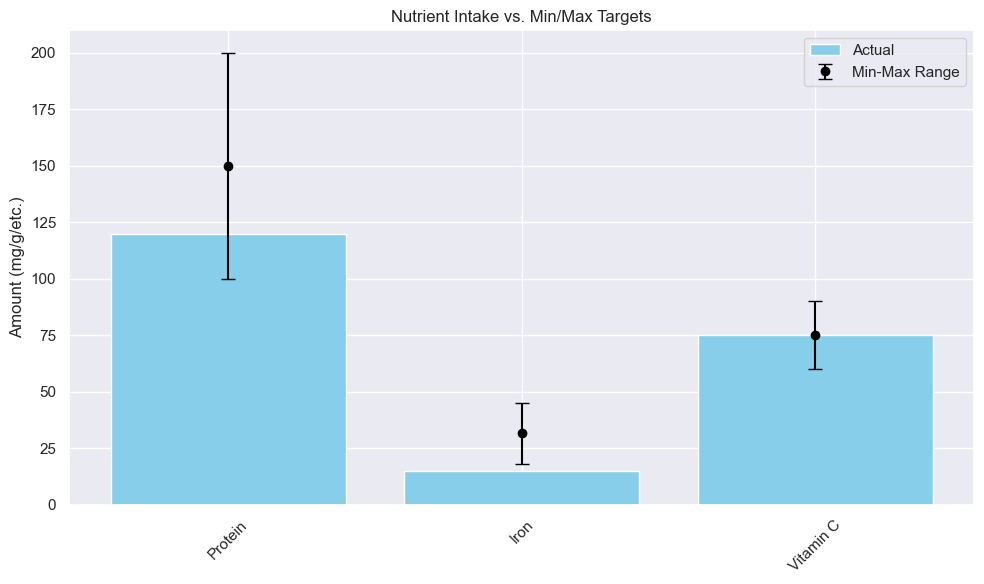

In [14]:
nutrients = ['Protein', 'Iron', 'Vitamin C']
actual = [120, 15, 75]
min_vals = [100, 18, 60]
max_vals = [200, 45, 90]

x = range(len(nutrients))

plt.figure(figsize=(10, 6))
plt.bar(x, actual, color='skyblue', label='Actual')
plt.errorbar(x, [(mi + ma)/2 for mi, ma in zip(min_vals, max_vals)],
             yerr=[(ma - mi)/2 for mi, ma in zip(min_vals, max_vals)],
             fmt='o', color='black', capsize=5, label='Min-Max Range')

plt.xticks(x, nutrients, rotation=45)
plt.ylabel('Amount (mg/g/etc.)')
plt.title('Nutrient Intake vs. Min/Max Targets')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
problem = pulp.LpProblem('optimize_diet', pulp.LpMinimize) # min difference between daily weight reduction goal and caloric intake

# variables
amt_vars = pulp.LpVariable.dicts(name='food amt', indices=food_df.index, lowBound = 0) # indices are food codes
selected_vars = pulp.LpVariable.dicts(name='selected', indices=food_df.index, cat='Binary')
pos_diff = pulp.LpVariable('pos_diff', lowBound=0)
neg_diff = pulp.LpVariable('neg_diff', lowBound=0)

total_calories = pulp.lpSum([amt_vars[food_code] * food_df.loc[food_code, 'energy_kcal'] for food_code in food_df.index])

# objective function
problem += pos_diff + neg_diff

# constraints
problem += calorie_goal_train - total_calories == pos_diff - neg_diff, 'model_difference'

age_group = ''
if 14 <= age <= 18:
    age_group = '14_18'
elif 19 <= age <= 30:
    age_group = '19_30'
elif 31 <= age <= 50:
    age_group = '31_50'
elif 51 <= age <= 70:
    age_group = '51_70'

# min intake constraints
min_nutrients = pd.Series(index=food_df.columns)[3:].fillna(0) # default minimum is 0

# fill in minimum amount constraints according to EAR, if recommended amount exists
for nutrient in ear_df.columns:
    if nutrient in min_nutrients.index: # check if nutrient exists in food df
        min_nutrients[nutrient] = ear_df.loc[(sex, age_group), nutrient]

# print(min_nutrients['vitamin_d_mcg'])
# print(ear_df.loc[('male', '19 to 30')])

Below are key performance nutrients recommended by AI. For the purposes of this project, I just used AI to summarize . . .

In [16]:
# increased minimum amounts for key performance nutrients

# macros
min_nutrients['protein_g'] = 2.0 * current_weight
min_nutrients['carbohydrate_g'] = 4.0 * current_weight # TODO: make sure weight changes with time
min_nutrients['fat_g'] = 1.0 * current_weight

# electrolytes: muscle cramp prevention
min_nutrients['sodium_mg'] = 500.0
min_nutrients['potassium_mg'] = 4000.0

# below values are lower than ear values
min_nutrients['magnesium_mg'] = 300.0
min_nutrients['calcium_mg'] = 1000.0 # muscle + bone health

# b vitamins: critical for energy metabolism
min_nutrients['thiamin_mg'] = 1.2
min_nutrients['riboflavin_mg'] = 1.3
min_nutrients['niacin_mg'] = 16.0
min_nutrients['vitamin_b6_mg'] = 1.3
min_nutrients['vitamin_b12_mcg'] = 2.4

# other
min_nutrients['iron_mg'] = 10.0 # oxygen transport — key for endurance
# min_nutrients['omega-3 (epa + dha) (g)'] = 1.5 # anti-inflammatory, 20:5 is epa, 22:6 is dha
min_nutrients['vitamin_d_mcg'] = 10.0 # often supplemented — immunity, bone
min_nutrients['zinc_mg'] = 10.0 # recovery, immune support
min_nutrients['vitamin_c_mg'] = 75.0 # immunity, collagen
min_nutrients['fiber_g'] = 25.0 # too much can bloat during cut phase

for nutrient in min_nutrients.index:
    if nutrient in food_df.columns:
        problem += pulp.lpSum([amt_vars[food_code] * food_df.loc[food_code, nutrient] for food_code in food_df.index]) >= min_nutrients[nutrient], f'min_{nutrient}'
    else:
        print(f"Warning: {nutrient} not found in food_df columns.")

In [ ]:
# max intake constraints
# max_nutrients_df = pd.concat([max_elements_df, max_vitamins_df], axis=1)

# TODO: change this
max_nutrients = pd.Series(index=food_df.columns)[3:].fillna(999999999) # no maximum by default
max_nutrients_df['caffeine_mg'] = [100, 400, 400, 400, 100, 400, 400, 400] # limit caffeine to 100 mg for children, 400 mg for adults

# fill in minimum amount constraints according to maximum daily intake levels, if recommended amount exists
for nutrient in max_nutrients_df.columns:
    if nutrient in max_nutrients.index: # check if nutrient exists in food df
        max_nutrients[nutrient] = max_nutrients_df.loc[(sex, age_group), nutrient]

for nutrient in max_nutrients.index:
    if nutrient in food_df.columns:
        problem += pulp.lpSum([amt_vars[food_code] * food_df.loc[food_code, nutrient] for food_code in food_df.index]) <= max_nutrients[nutrient], f'max_{nutrient}'
    else:
        print(f"Warning: {nutrient} not found in food_df columns.")

# constraint 3: min 0.5 servings
for food_code in food_df.index:
    problem += amt_vars[food_code] >= 0.1 * selected_vars[food_code]
    problem += amt_vars[food_code] <= 5 * selected_vars[food_code] # linking constraint to ensure that 'selected' is 1 when 'food amt' > 0

from collections import defaultdict

# constraint 4: max 1 food from each category
category_foods = defaultdict(list)
for food_code, category in food_df['wweia_category_number'].items():
    category_foods[category].append(food_code)
for category, food_codes in category_foods.items():
    problem += pulp.lpSum(selected_vars[food_code] for food_code in food_codes) <= 1, f'one_per_category_{category}'

# Constraint: unwanted foods (such as baby food)
problem += pulp.lpSum(selected_vars[food_code] for food_code in category_foods[9002]) == 0, f'no_baby_food_{food_df.loc[food_code]}'

# macro kcal/g
CARB_KCAL_PER_G = 4
FAT_KCAL_PER_G = 9
PROTEIN_KCAL_PER_G = 4

# total_energy = CARB_KCAL_PER_G * amt_vars['Carbohydrate (g)'] + FAT_KCAL_PER_G * amt_vars['Total Fat (g)'] + PROTEIN_KCAL_PER_G * amt_vars['Protein (g)']

# print(min_nutrients.index)
# print(food_df.loc[11114300, 'Zinc (mg)'])

# solve w/o printing output
problem.solve(pulp.PULP_CBC_CMD(msg=False))

total_caff = 0
total_energy = 0
total_sodium = 0
# print non-zero results
for food_code in amt_vars:
    if amt_vars[food_code].varValue > 0:
        total_caff += amt_vars[food_code].varValue * food_df.loc[food_code, 'caffeine_mg']
        total_energy += amt_vars[food_code].varValue * food_df.loc[food_code, 'energy_kcal']
        total_sodium += amt_vars[food_code].varValue * food_df.loc[food_code, 'sodium_mg']
        print(f'{food_df.loc[food_code, 'main_food_description']}: {amt_vars[food_code].varValue:.2f} servings')

# print(f'total caffeine: {total_caff}')
print(f'Total Energy: {total_energy:.2f} kcal')
print(f'Total Sodium: {total_sodium:.2f} mg')

**Problem 1**

Here, you can see that my results match the optimal solution stated in the homework description.

**Problem 2**

In [ ]:
# problem 2
prob2 = pulp.LpProblem('army_nut', pulp.LpMinimize)

# variables
amt_vars = pulp.LpVariable.dicts(name='food amt', indices=food_df['Foods'], lowBound=0)
selected_vars = pulp.LpVariable.dicts(name='selected', indices=food_df['Foods'], cat='Binary')

# objective function
prob2 += pulp.lpSum([amt_vars[food] * food_df.loc[food_df['Foods'] == food, ]['Price/ Serving'].iloc[0] for food in food_df['Foods']]), 'total cost'

# daily intake constraints
for nut in limit_df.columns[1:]:
    min_nut = limit_df[nut].iloc[0]
    max_nut = limit_df[nut].iloc[1]

    prob2 += pulp.lpSum([amt_vars[food] * food_df.loc[food_df['Foods'] == food, ][nut].iloc[0] for food in food_df['Foods']]) >= min_nut, f'min_{nut}'
    prob2 += pulp.lpSum([amt_vars[food] * food_df.loc[food_df['Foods'] == food, ][nut].iloc[0] for food in food_df['Foods']]) <= max_nut, f'max_{nut}'

# constraint a: min 0.1 servings
for food in food_df['Foods']:
    prob2 += amt_vars[food] >= 0.1 * selected_vars[food]
    prob2 += amt_vars[food] <= 1000 * selected_vars[food] # linking constraint to ensure that 'selected' is 1 when 'food amt' > 0

# constraint b: cannot select both celery and broccoli
prob2 += selected_vars['Celery, Raw'] + selected_vars['Frozen Broccoli'] <= 1

# constraint c: at least 3 different types of protein excluding tacos (ambiguous), tofu, and soups
# protein types for constraint c
meat_types = ['Frankfurter, Beef', 'Ham,Sliced,Extralean', 'Kielbasa,Prk', 'Pork', 'Hamburger W/Toppings', 'Hotdog, Plain']
poultry_types = ['Roasted Chicken', 'Bologna,Turkey']
fish_types = ['Sardines in Oil', 'White Tuna in Water']
egg_types = ['Poached Eggs', 'Scrambled Eggs']

# vars for constraint c
meat_selected = pulp.LpVariable('meat_selected', cat='Binary')
poultry_selected = pulp.LpVariable('poultry_selected', cat='Binary')
fish_selected = pulp.LpVariable('fish_selected', cat='Binary')
egg_selected = pulp.LpVariable('egg_selected', cat='Binary')

# linking constraints for constraint c
prob2 += meat_selected <= pulp.lpSum([selected_vars[food] for food in meat_types if food in selected_vars])
prob2 += poultry_selected <= pulp.lpSum([selected_vars[food] for food in poultry_types if food in selected_vars])
prob2 += fish_selected <= pulp.lpSum([selected_vars[food] for food in fish_types if food in selected_vars])
prob2 += egg_selected <= pulp.lpSum([selected_vars[food] for food in egg_types if food in selected_vars])

# constraint c
prob2 += meat_selected + poultry_selected + fish_selected + egg_selected >= 3

# solve w/o printing output
prob2.solve(pulp.PULP_CBC_CMD(msg=False))

# print non-zero results
for food in amt_vars:
    if amt_vars[food].varValue > 0:
        print(f'{food}: {amt_vars[food].varValue} servings')

KeyError: 'Foods'

I interpreted constraint C as requiring at least 1 protein from at least 3 of the 4 stated protein types (meat, poultry, fish, eggs), since the goal is to include a variety of protein sources in the diet. Here, I have 1 poultry (turkey bologna), 1 meat (pork kielbasa), and poached eggs. Since there is at least 0.1 servings of each item and the diet does not include broccoli, constraints A and B are also met.